In [65]:
import pandas as pd
from math import sqrt;
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression;
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix, mean_absolute_error, mean_squared_error, f1_score, log_loss
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.externals import joblib 

In [66]:
#Importing Datasets 
malicious_dataset = pd.read_csv('insert malicious file name.csv')
benign_dataset = pd.read_csv('insert benign file name.csv')

# Removing duplicated rows from benign_dataset (5380 rows removed)
benign_dataset = benign_dataset[benign_dataset.duplicated(keep=False) == False]

print(benign_dataset.duplicated(keep=False).value_counts())
print(malicious_dataset.duplicated(keep=False).value_counts())

# Combining both datasets together
all_flows = pd.concat([malicious_dataset, benign_dataset])

#Inspecting datasets for columns and rows with missing values
missing_values = all_flows.isnull().sum()
overall_percentage = (missing_values/all_flows.isnull().count())
print(overall_percentage)

# Reducing the size of the dataset to reduce the amount of time taken in training models
reduced_dataset = all_flows.sample(78000)

validation_dataset = pd.read_csv('insert validation file name')
validation_dataset = validation_dataset[validation_dataset.duplicated(keep=False) == False]

# Examining the distribution of Malicious and Benign flows in the reduced dataset 
print(reduced_dataset['isMalware'].value_counts())

False    62604
dtype: int64
False    16467
dtype: int64
Src_Port     0.0
Dst_Port     0.0
Bytes_in     0.0
Bytes_out    0.0
Pkts_in      0.0
            ... 
sg_24        0.0
sg_25        0.0
ec_pts_0     0.0
ec_pts_1     0.0
isMalware    0.0
Length: 439, dtype: float64
0    55436
1    14564
Name: isMalware, dtype: int64


In [67]:
# Isolating independent and dependent variables for training dataset
reduced_y = reduced_dataset['isMalware']
reduced_x = reduced_dataset.drop(['isMalware'], axis=1);

# Isolating independent and dependent variables for validation dataset
validation_y = validation_dataset['isMalware']
validation_x = validation_dataset.drop(['isMalware'], axis=1);

# Splitting datasets into training and test data
x_train, x_test, y_train, y_test = train_test_split(reduced_x, reduced_y, test_size=0.2, random_state=42)

In [68]:
# Training random forest classifier
rf_clf = RandomForestClassifier(max_depth=100)
rf_clf.fit(x_train, y_train) 
rf_prediction = rf_clf.predict(x_test)
conf_m = confusion_matrix(y_test, rf_prediction)  
print(conf_m)
print('Random Forest Classifier Accuracy score: ', accuracy_score(y_test, rf_prediction))

rf_validation_prediction = rf_clf.predict(validation_x)
print('Random Forest Classifier with validation set Accuracy score: ', accuracy_score(rf_validation_prediction, validation_y))

[[11065     0]
 [    4  2931]]
Random Forest Classifier Accuracy score:  0.9997142857142857
Random Forest Classifier with validation set Accuracy score:  0.9999551468939224


In [69]:
# Training Logistics Regression classifier
lm = LogisticRegression(max_iter=70000)
lm.fit(x_train,y_train)
predictions = lm.predict(x_test)
rms = sqrt(mean_squared_error(y_test, predictions))
print('Mean Absolute Error: ', mean_absolute_error(y_test, predictions))
print('Root Mean Squared Error: ',rms)
print('R Squared Score: ', r2_score(y_test, predictions))
print('Accuracy score: ', accuracy_score(predictions, y_test))

Mean Absolute Error:  0.004857142857142857
Root Mean Squared Error:  0.06969320524371696
R Squared Score:  0.9706858419852952
Accuracy score:  0.9951428571428571


In [70]:
#Testing the accuracy of the logistic regression model on the validation dataset
validation_predictions = lm.predict(validation_x)
rms = sqrt(mean_squared_error(validation_y, validation_predictions))
print('Mean Absolute Error: ', mean_absolute_error(validation_y, validation_predictions))
print('Root Mean Squared Error: ',rms)
print('R Squared Score: ', r2_score(validation_y, validation_predictions))
print('Accuracy score: ', accuracy_score(validation_predictions, validation_y))

Mean Absolute Error:  0.0033639829558196905
Root Mean Squared Error:  0.05799985306722501
R Squared Score:  0.0
Accuracy score:  0.9966360170441803


In [71]:
#Confusion matrix for test set accuracy
conf_m_lr = confusion_matrix(y_test, predictions)  
print(conf_m_lr)

[[11039    26]
 [   42  2893]]


In [72]:
# Importing cipher stunted datasets 
cipher_stunted_dataset = pd.read_csv('Insert cipher stunted file name')

# Removing duplicated rows from benign_dataset_test
cipher_stunted_dataset = cipher_stunted_dataset[cipher_stunted_dataset.duplicated(keep=False) == False]

print(cipher_stunted_dataset.duplicated(keep=False).value_counts())

#Inspecting datasets for columns and rows with missing values
test_missing_values = cipher_stunted_dataset.isnull().sum()
test_overall_percentage = (test_missing_values/cipher_stunted_dataset.isnull().count())

cs_test_x, cs_test_y = cipher_stunted_dataset.drop(['isMalware'], axis=1), cipher_stunted_dataset['isMalware']

False    16467
dtype: int64


In [73]:
cs_test_predictions = lm.predict(cs_test_x)
#print(test_predictions)

In [74]:
conf_m_lr_cs = confusion_matrix(cs_test_y, cs_test_predictions)  
print(conf_m_lr_cs)

[[    0     0]
 [16460     7]]


In [75]:
print('Logistics Regression Accuracy score: ', accuracy_score(cs_test_predictions, cs_test_y))

Logistics Regression Accuracy score:  0.0004250926094613469


In [76]:
rf_validation_prediction_2 = rf_clf.predict(cs_test_x)
print('Random Forest Classifier Accuracy score: ', accuracy_score(rf_validation_prediction_2, cs_test_y))

Random Forest Classifier Accuracy score:  1.0


In [77]:
conf_m_lr_cs = confusion_matrix(cs_test_y, rf_validation_prediction_2)  
print(conf_m_lr_cs)

[[16467]]


In [78]:
#Function to plot most important features of random forest model

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.ylim(0, 50)
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


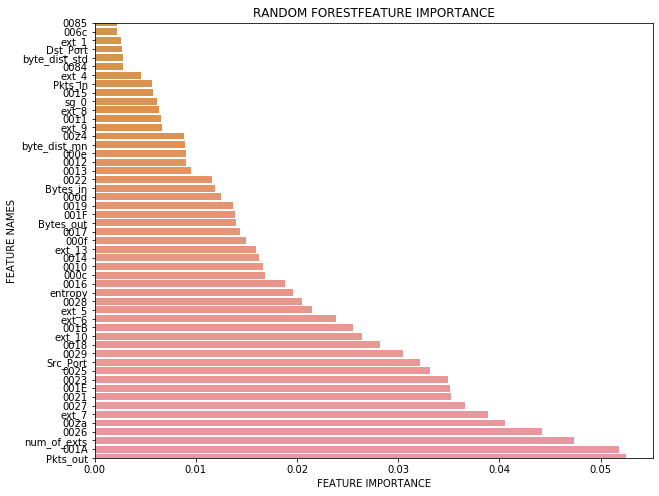

In [79]:
plot_feature_importance(rf_clf.feature_importances_,x_train.columns,'RANDOM FOREST') 


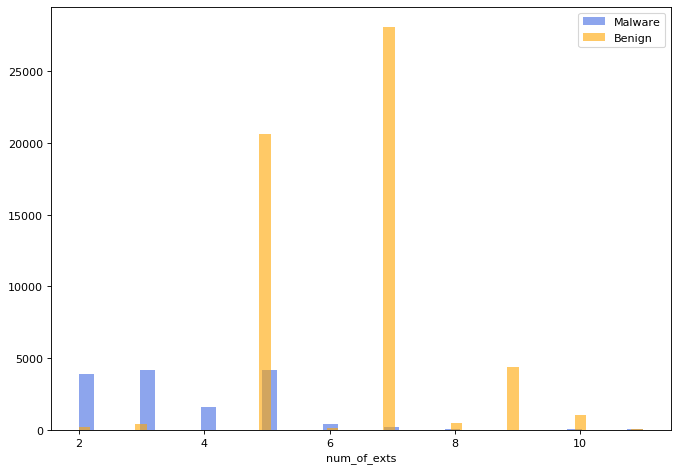

In [80]:
x1 = reduced_dataset.loc[reduced_dataset.isMalware==1, 'num_of_exts']
x2 = reduced_dataset.loc[reduced_dataset.isMalware==0, 'num_of_exts']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(x1, color="royalblue", label="Malware", **kwargs, kde=False)
sns.distplot(x2, color="orange", label="Benign", **kwargs, kde=False)

plt.legend();
plt.show()

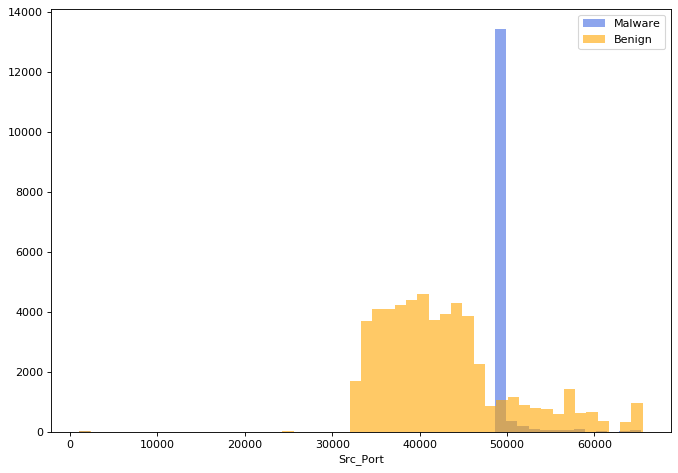

In [81]:
x1 = reduced_dataset.loc[reduced_dataset.isMalware==1, 'Src_Port']
x2 = reduced_dataset.loc[reduced_dataset.isMalware==0, 'Src_Port']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(x1, color="royalblue", label="Malware", **kwargs, kde=False)
sns.distplot(x2, color="orange", label="Benign", **kwargs, kde=False)

plt.legend();
plt.show()

In [82]:
#Saving the random forest and logistics regression models
joblib.dump(rf_clf, 'random_forest_model.pkl')
joblib.dump(lm, 'logistics_regression_classifier.pkl')

# Load the model from the file
rf_from_joblib = joblib.load('random_forest_model.pkl')
lm_from_joblib = joblib.load('logistics_regression_classifier.pkl') 

# Use the loaded model to make predictions
results = rf_from_joblib.predict(x_test)
results = lm_from_joblib.predict(x_test)
print('Random Forest Classifier Accuracy score: ', accuracy_score(y_test, results))

Random Forest Classifier Accuracy score:  0.9951428571428571


In [83]:
# Load the model from the file
rf_from_joblib = joblib.load('random_forest_model.pkl')

In [85]:
#Cipher and extension stunded dataset tests
cs_ex_stunted_dataset = pd.read_csv('Insert cipher stunted file name')
cs_ex_stunted_dataset = cs_ex_stunted_dataset[cs_ex_stunted_dataset.duplicated(keep=False) == False]
cs_ex_test_x, cs_ex_test_y = cs_ex_stunted_dataset.drop(['isMalware'], axis=1), cs_ex_stunted_dataset['isMalware']
results = rf_from_joblib.predict(cs_ex_test_x)
print('Random Forest Classifier Accuracy score: ', accuracy_score(cs_ex_test_y, results))

Random Forest Classifier Accuracy score:  0.8588692536588328


In [86]:
#Cipher, extension, and source port stunted results
cs_ex_sp_stunted_dataset = pd.read_csv('Insert cipher stunted file name')
cs_ex_sp_stunted_dataset = cs_ex_sp_stunted_dataset[cs_ex_sp_stunted_dataset.duplicated(keep=False) == False]
cs_ex_sp_test_x, cs_ex_sp_test_y = cs_ex_sp_stunted_dataset.drop(['isMalware'], axis=1), cs_ex_sp_stunted_dataset['isMalware']
results = rf_from_joblib.predict(cs_ex_sp_test_x)
print('Random Forest Classifier Accuracy score: ', accuracy_score(cs_ex_sp_test_y, results))

Random Forest Classifier Accuracy score:  0.5675593611465355


In [87]:
#Cipher, extension, source port, and packet out stunted results
cs_ex_sp_po_stunted_dataset = pd.read_csv('Insert cipher stunted file name')
cs_ex_sp_po_stunted_dataset = cs_ex_sp_po_stunted_dataset[cs_ex_sp_po_stunted_dataset.duplicated(keep=False) == False]
cs_ex_sp_po_test_x, cs_ex_sp_po_test_y = cs_ex_sp_po_stunted_dataset.drop(['isMalware'], axis=1), cs_ex_sp_po_stunted_dataset['isMalware']
results = rf_from_joblib.predict(cs_ex_sp_po_test_x)
print('Random Forest Classifier Accuracy score: ', accuracy_score(cs_ex_sp_po_test_y, results))

Random Forest Classifier Accuracy score:  0.6059998785449687


In [88]:
#Training new models with original and cipher stunted data

In [89]:
# Combining all datasets together
new_all_flows = pd.concat([malicious_dataset, benign_dataset, cipher_stunted_dataset, cs_ex_stunted_dataset, cs_ex_sp_stunted_dataset, cs_ex_sp_po_stunted_dataset])

# Examining combined dataset
print(new_all_flows['isMalware'].value_counts())

1    82335
0    62604
Name: isMalware, dtype: int64


In [90]:
# Isolating independent and dependent variables for new combined dataset
new_all_flows_y = new_all_flows['isMalware']
new_all_flows_x = new_all_flows.drop(['isMalware'], axis=1);

# Splitting datasets into training and test data
combined_x_train, combined_x_test, combined_y_train, combined_y_test = train_test_split(new_all_flows_x, new_all_flows_y, test_size=0.2, random_state=42)

In [91]:
#Training new RF classifier
combined_rf_clf = RandomForestClassifier(max_depth=100)
combined_rf_clf.fit(combined_x_train, combined_y_train) 
combined_rf_prediction = combined_rf_clf.predict(combined_x_test)
combined_conf_m = confusion_matrix(combined_y_test, combined_rf_prediction)  
print(combined_conf_m)
print('Random Forest Classifier Accuracy score: ', accuracy_score(combined_y_test, combined_rf_prediction))

[[12541     0]
 [   10 16437]]
Random Forest Classifier Accuracy score:  0.9996550296674486


In [ ]:
# Testing combined Logistics Regression classifier on datasets
combined_lm = LogisticRegression(max_iter=100000)
combined_lm.fit(combined_x_train,combined_y_train)
combined_lm_predictions = combined_lm.predict(combined_x_test)
combined_rms = sqrt(mean_squared_error(combined_y_test, combined_lm_predictions))
print('Mean Absolute Error: ', mean_absolute_error(combined_y_test, combined_lm_predictions))
print('Root Mean Squared Error: ',combined_rms)
print('R Squared Score: ', r2_score(combined_y_test, combined_lm_predictions))
print('Accuracy score: ', accuracy_score(combined_lm_predictions, combined_y_test))

In [ ]:
combined_rf_prediction_2 = combined_rf_clf.predict(sample_benign_flows_x)

combined_lm_predictions_2 = combined_lm.predict(sample_benign_flows_x)

# Testing on unseen sample benign dataset for combined rf classifier
print('Random Forest Classifier Accuracy score: ', accuracy_score(sample_benign_flows_y, combined_rf_prediction_2))

# Testing on unseen sample benign dataset for logistics regression classifier
print('Random Forest Classifier Accuracy score: ', accuracy_score(sample_benign_flows_y, combined_lm_predictions_2))

In [ ]:
#Cipher stunted results
new_cs_stunted_dataset = pd.read_csv('Insert cipher stunted file name')
new_cs_stunted_dataset = new_cs_stunted_dataset[new_cs_stunted_dataset.duplicated(keep=False) == False]
new_cs_stunted_dataset_x, new_cs_stunted_dataset_y = new_cs_stunted_dataset.drop(['isMalware'], axis=1), new_cs_stunted_dataset['isMalware']
results = combined_rf_clf.predict(new_cs_stunted_dataset_x)
print('Random Forest Classifier Accuracy score: ', accuracy_score(new_cs_stunted_dataset_y, results))

In [ ]:
#Cipher and extension stunted results
new_cs_ex_stunted_dataset = pd.read_csv('Insert cipher stunted file name')
new_cs_ex_stunted_dataset = new_cs_ex_stunted_dataset[new_cs_ex_stunted_dataset.duplicated(keep=False) == False]
new_cs_ex_stunted_dataset_x, new_cs_ex_stunted_dataset_y = new_cs_ex_stunted_dataset.drop(['isMalware'], axis=1), new_cs_ex_stunted_dataset['isMalware']
results = combined_rf_clf.predict(new_cs_ex_stunted_dataset_x)
print('Random Forest Classifier Accuracy score: ', accuracy_score(new_cs_ex_stunted_dataset_y, results))

In [ ]:
#Cipher, extension, and source port stunted results
new_cs_ex_sp_stunted_malicious_dataset = pd.read_csv('Insert cipher stunted file name')
new_cs_ex_sp_stunted_malicious_dataset = new_cs_ex_sp_stunted_malicious_dataset[new_cs_ex_sp_stunted_malicious_dataset.duplicated(keep=False) == False]
new_cs_ex_sp_stunted_malicious_dataset_x, new_cs_ex_sp_stunted_malicious_dataset_y = new_cs_ex_sp_stunted_malicious_dataset.drop(['isMalware'], axis=1), new_cs_ex_sp_stunted_dataset['isMalware']
results = combined_rf_clf.predict(new_cs_ex_sp_stunted_malicious_dataset_x)
print('Random Forest Classifier Accuracy score: ', accuracy_score(new_cs_ex_sp_stunted_malicious_dataset_y, results))

In [ ]:
#Cipher, extension, source port, and packets out stunted results
new_cs_ex_sp_po_stunted_dataset = pd.read_csv('Insert cipher stunted file name')
new_cs_ex_sp_po_stunted_dataset = new_cs_ex_sp_po_stunted_dataset[new_cs_ex_sp_po_stunted_dataset.duplicated(keep=False) == False]
new_cs_ex_sp_po_stunted_dataset_x, new_cs_ex_sp_po_stunted_dataset_y = new_cs_ex_sp_po_stunted_dataset.drop(['isMalware'], axis=1), new_cs_ex_sp_po_stunted_dataset['isMalware']
results = combined_rf_clf.predict(new_cs_ex_sp_po_stunted_dataset_x)
print('Random Forest Classifier Accuracy score: ', accuracy_score(new_cs_ex_sp_po_stunted_dataset_y, results))

In [ ]:
lm_predictions_cs_ex = combined_lm.predict(new_cs_ex_stunted_dataset_x)
print('Accuracy score: ', accuracy_score(lm_predictions_cs_ex, new_cs_ex_stunted_dataset_y))

In [ ]:
lm_predictions_cs_ex_sp = combined_lm.predict(new_cs_ex_sp_stunted_malicious_dataset_x)
print('Accuracy score: ', accuracy_score(lm_predictions_cs_ex_sp, new_cs_ex_sp_stunted_malicious_dataset_y))

In [ ]:
lm_predictions_cs_ex_sp_po = combined_lm.predict(new_cs_ex_sp_po_stunted_dataset_x)
print('Accuracy score: ', accuracy_score(lm_predictions_cs_ex_sp_po, new_cs_ex_sp_po_stunted_dataset_y))

In [ ]:
joblib.dump(combined_rf_clf, 'new_random_forest_model.pkl')
joblib.dump(combined_lm, 'new_logistics_regression_classifier.pkl')